In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline  import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

### Import 2 food Dataframes as DF & Df_new and combine them on ID

In [112]:
df = pd.read_csv('https://query.data.world/s/4rc3ue7y43lgazmy44xhxpn32mfujo')
df.head(3)

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909


In [113]:
df_new = pd.read_excel('https://query.data.world/s/twh3fzbktso2x5z5dlr7yal2ntdfks')
df_new.head(3)

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,...,7.0,51.368,21.021,3.043,215.0,5.0,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,...,4.6,45.390,19.874,3.331,225.0,3.8,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,8.6,61.924,28.732,3.694,256.0,12.8,1 tbsp,205.0,1 cup,0.0


### Investigate final df and drop missing rows
- tried simple impute before and it didn't work (will drop na instead)

In [114]:
final_df2 = pd.merge(left=df[['ID', 'FoodGroup','Protein_g', 'VitA_mcg']], 
                    right=df_new[['NDB_No','Shrt_Desc','Vit_D_µg', 'Vit_E_(mg)' , 'Vit_B12_(µg)','Vit_C_(mg)' , 'Calcium_(mg)', 'Iron_(mg)' , 'Potassium_(mg)' ,'FA_Mono_(g)','Folate_Tot_(µg)']],
                    left_on = 'ID',
                    right_on ='NDB_No', 
                    how='right').drop(columns='ID')

In [115]:
#inspect
final_df2.isna().sum()

FoodGroup           371
Protein_g           371
VitA_mcg            371
NDB_No                0
Shrt_Desc             0
Vit_D_µg           3262
Vit_E_(mg)         2889
Vit_B12_(µg)       1193
Vit_C_(mg)          818
Calcium_(mg)        348
Iron_(mg)           144
Potassium_(mg)      426
FA_Mono_(g)         666
Folate_Tot_(µg)    1261
dtype: int64

In [116]:
final_df2.dropna(inplace=True)
final_df2.reset_index(drop=True, inplace=True)

final_df2.shape # (6330,13) now (4275,12)

(4215, 14)

### Find the Nutrition density of food based on certain nutritions

In [117]:
def findND(df):
    '''This funciton takes a df and returns a list of the nutrient density 
    for each food in the df. The nutrient density is found by summing the nutrients from
    vitamins and minerals in a food'''

    #take each nutrient and convert to grams
    protein = (df['Protein_g'])
    vitA = ((df['VitA_mcg']/1_000_000))
    vitD = ((df['Vit_D_µg']/100))
    vitE = ((df['Vit_E_(mg)']/1_000_000))
    vitb12 = ((df['Vit_B12_(µg)']/100_000))
    calcium = ((df['Calcium_(mg)']/1_000_000))
    iron = ((df['Iron_(mg)']/1_000_000))
    vitC = ((df['Vit_C_(mg)']/1_000_000))
    potassium = ((df['Potassium_(mg)']/1_000_000))
    fatty_acids = ((df['FA_Mono_(g)']))
    folate = ((df['Folate_Tot_(µg)']/100_000))
    
    nutrition_density = []
    for i in range(len(protein)):
        density = protein[i]+vitA[i]+ vitD[i]+ vitE[i]+ vitb12[i]+ calcium[i]+ iron[i]+vitC[i]+potassium[i]+ fatty_acids[i]+folate[i]
        nutrition_density.append(round(density)/12)
        
    return(nutrition_density)

In [118]:
#test the function and inspect
density = findND(final_df2)
np.mean(density) # 1.245
min(density) #0
max(density)#7.16

pd.DataFrame(density).isna().sum() # 0 - searching for nans in formula

0    0
dtype: int64

In [119]:
#assign Nutrion density column
final_df2['Nutrition Density'] = density

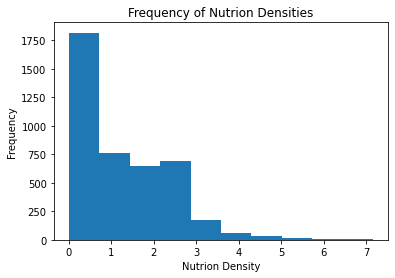

In [120]:
plt.hist(density);

plt.xlabel('Nutrion Density')
plt.ylabel('Frequency')
plt.title('Frequency of Nutrion Densities');

In [121]:
#score each of the food groups manually
final_df2.loc[final_df2['FoodGroup'] == 'Dairy and Egg Products', 'storage'] = 1
final_df2.loc[final_df2['FoodGroup'] == 'Spices and Herbs', 'storage'] = 5
final_df2.loc[final_df2['FoodGroup'] == 'Baby Foods', 'storage'] = 3
final_df2.loc[final_df2['FoodGroup'] == 'Fats and Oils', 'storage'] = 5
final_df2.loc[final_df2['FoodGroup'] == 'Poultry Products', 'storage'] = 1
final_df2.loc[final_df2['FoodGroup'] == 'Soups, Sauces, and Gravies', 'storage'] = 4
final_df2.loc[final_df2['FoodGroup'] == 'Sausages and Luncheon Meats', 'storage'] = 2
final_df2.loc[final_df2['FoodGroup'] == 'Breakfast Cereals', 'storage'] = 10
final_df2.loc[final_df2['FoodGroup'] == 'Fruits and Fruit Juices', 'storage'] = 4
final_df2.loc[final_df2['FoodGroup'] == 'Pork Products', 'storage'] = 2
final_df2.loc[final_df2['FoodGroup'] == 'Vegetables and Vegetable Products', 'storage'] = 3
final_df2.loc[final_df2['FoodGroup'] == 'Nut and Seed Products', 'storage'] = 10
final_df2.loc[final_df2['FoodGroup'] == 'Beef Products', 'storage'] = 2
final_df2.loc[final_df2['FoodGroup'] == 'Beverages', 'storage'] = 10
final_df2.loc[final_df2['FoodGroup'] == 'Finfish and Shellfish Products', 'storage'] = 1
final_df2.loc[final_df2['FoodGroup'] == 'Lamb, Veal, and Game Products', 'storage'] = 2
final_df2.loc[final_df2['FoodGroup'] == 'Baked Products', 'storage'] = 5
final_df2.loc[final_df2['FoodGroup'] == 'Sweets', 'storage'] = 10
final_df2.loc[final_df2['FoodGroup'] == 'Cereal Grains and Pasta', 'storage'] = 10
final_df2.loc[final_df2['FoodGroup'] == 'Fast Foods', 'storage'] = 1
final_df2.loc[final_df2['FoodGroup'] == 'Meals, Entrees, and Side Dishes', 'storage'] = 2
final_df2.loc[final_df2['FoodGroup'] == 'Snacks', 'storage'] = 9
final_df2.loc[final_df2['FoodGroup'] == 'American Indian/Alaska Native Foods', 'storage'] = 3
final_df2.loc[final_df2['FoodGroup'] == 'Restaurant Foods', 'storage'] = 1
final_df2.loc[final_df2['FoodGroup'] == 'Legumes and Legume Products', 'storage'] = 9



### Determind the score of the foods by standardizing

In [123]:
#standardize the daily values and storage, then add them to determind score
scores = (final_df2['Nutrition Density'] -  final_df2['Nutrition Density'].mean())/ final_df2['Nutrition Density'].std() + \
                      (final_df2['storage'] - final_df2['storage'].mean())/final_df2['storage'].std()
final_df2['Donation Score'] = round(scores + 3,2)

#inspect df
final_df2.head(2)

,FoodGroup,Protein_g,VitA_mcg,NDB_No,Shrt_Desc,Vit_D_µg,Vit_E_(mg),Vit_B12_(µg),Vit_C_(mg),Calcium_(mg),Iron_(mg),Potassium_(mg),FA_Mono_(g),Folate_Tot_(µg),Nutrition Density,storage,Donation Score
0,Dairy and Egg Products,0.85,684.0,1001,"BUTTER,WITH SALT",0.0,2.32,0.17,0.0,24.0,0.02,24.0,21.021,3.0,1.833333,1.0,2.47
1,Dairy and Egg Products,0.85,684.0,1002,"BUTTER,WHIPPED,W/ SALT",0.0,1.37,0.07,0.0,23.0,0.05,41.0,19.874,4.0,1.750000,1.0,2.40


In [125]:
food_array=[]
for item in final_df2['Shrt_Desc']:
    item_list = item.split(",")
    food_array.append(item_list)

new_word =''
new_list = []
for lst in food_array:
    for word in lst:
        new_word += word + ' '
        #print(new_word)
    new_list.append(new_word[:-1])
    new_word = ''
 

In [126]:
final_df2['Food Names'] = new_list
final_df2.head()

,FoodGroup,Protein_g,VitA_mcg,NDB_No,Shrt_Desc,Vit_D_µg,Vit_E_(mg),Vit_B12_(µg),Vit_C_(mg),Calcium_(mg),Iron_(mg),Potassium_(mg),FA_Mono_(g),Folate_Tot_(µg),Nutrition Density,storage,Donation Score,Food Names
0,Dairy and Egg Products,0.85,684.0,1001,"BUTTER,WITH SALT",0.0,2.32,0.17,0.0,24.0,0.02,24.0,21.021,3.0,1.833333,1.0,2.47,BUTTER WITH SALT
1,Dairy and Egg Products,0.85,684.0,1002,"BUTTER,WHIPPED,W/ SALT",0.0,1.37,0.07,0.0,23.0,0.05,41.0,19.874,4.0,1.750000,1.0,2.40,BUTTER WHIPPED W/ SALT
2,Dairy and Egg Products,0.28,840.0,1003,"BUTTER OIL,ANHYDROUS",0.0,2.80,0.01,0.0,4.0,0.00,5.0,28.732,0.0,2.416667,1.0,2.98,BUTTER OIL ANHYDROUS
3,Dairy and Egg Products,21.40,198.0,1004,"CHEESE,BLUE",0.5,0.25,1.22,0.0,528.0,0.31,256.0,7.778,36.0,2.416667,1.0,2.98,CHEESE BLUE
4,Dairy and Egg Products,23.24,292.0,1005,"CHEESE,BRICK",0.5,0.26,1.26,0.0,674.0,0.43,136.0,8.598,20.0,2.666667,1.0,3.20,CHEESE BRICK


In [127]:
#final_df2.to_csv('food_score.csv')

In [76]:
final_df2['Donation Score'].isna().sum() #0

0

<AxesSubplot:>

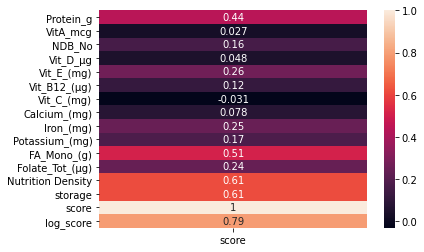

In [77]:
#Use a heatmap to see which features are correlated to the score
sns.heatmap(final_df2.corr()[['score']],annot = True)

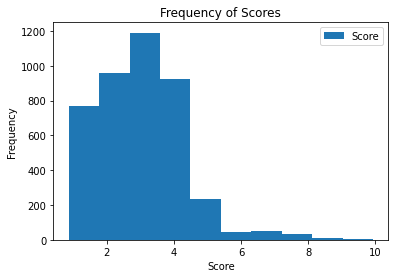

In [129]:
plt.hist(final_df2['Donation Score'], label = 'Score')
#plt.hist(final_df2['log_score'], label = 'Log score');
#plt.hist(final_df2['sum_score'], label = 'sum score');
plt.xlabel('Score');
plt.ylabel('Frequency');
plt.legend()
plt.title('Frequency of Scores');

The graphs above shows that the log score has a more normal distribution than the original score. Moving forward, we'll predict the log score to have a normal distribution of errors after standardizing the daily value and storage of foods

In [79]:
final_df2.isna().sum() # some na's because we have negetive scores after scaling

FoodGroup               0
Protein_g               0
VitA_mcg                0
NDB_No                  0
Shrt_Desc               0
Vit_D_µg                0
Vit_E_(mg)              0
Vit_B12_(µg)            0
Vit_C_(mg)              0
Calcium_(mg)            0
Iron_(mg)               0
Potassium_(mg)          0
FA_Mono_(g)             0
Folate_Tot_(µg)         0
Nutrition Density       0
storage                 0
score                   0
log_score            2277
dtype: int64

### Determine baseline by predicting average score

In [130]:
y = final_df2['Donation Score']
mean_squared_error(y, np.full_like(y,final_df2['Donation Score'].mean())) # 1.5

1.5108041992826275

### Apply all continuous features to linear regression pipeline

In [131]:
#Assign X & Y
X = final_df2[['Protein_g', 'VitA_mcg', 'Vit_D_µg','Vit_E_(mg)', 'Vit_B12_(µg)', 'Vit_C_(mg)', 'Calcium_(mg)', 'Iron_(mg)',
       'Potassium_(mg)', 'FA_Mono_(g)', 'Folate_Tot_(µg)']]
y = final_df2['Donation Score']

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#assign pip with SS
pipe_lr = make_pipeline(StandardScaler(),
                       LinearRegression())

#fit pipe
pipe_lr.fit(X_train,y_train)

#score on trian 
pipe_lr.score(X_train,y_train) #505

#score on test
pipe_lr.score(X_test,y_test) #0.49

0.4945418866077491

The continuous features that were considred for the Daily Value of food don't seem to help performance when predicting the the nutrition score. Its better than th base but we can do better. We can add food group feature to see how the model performs.

### Apply linear regression pipeline on entire dataset

In [132]:
#Assign X & y 
X = final_df2[['FoodGroup','Protein_g', 'VitA_mcg', 'Vit_D_µg','Vit_E_(mg)', 'Vit_B12_(µg)', 'Vit_C_(mg)', 'Calcium_(mg)', 'Iron_(mg)',
       'Potassium_(mg)', 'FA_Mono_(g)', 'Folate_Tot_(µg)']]
y = final_df2['Donation Score']

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#Apply column transformer to food group
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('FoodGroup')) )
                                   
#apply pipeline to w. SS
pipe_lr = make_pipeline(trans_col,
                        StandardScaler(),
                       LinearRegression())
#fit model
pipe_lr.fit(X_train,y_train)

#score on train 
pipe_lr.score(X_train,y_train) #0.7358

#score on test
pipe_lr.score(X_test,y_test) #0.74437

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.7443833616105514

Our initial prediction performs better than the base! We can build on this model to see what changes helps performance

### Apply Linear Regressor pipeline on foodgroup

In [133]:
#Assign X & y
X = final_df2[['FoodGroup']]
y = final_df2['Donation Score']

#check x
X.head(2)

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#Select columns to OHE
trans_col = make_column_transformer((OneHotEncoder(use_cat_names=True), make_column_selector('FoodGroup')) )
                                   
#pass through pipe!
pipe_lr = make_pipeline(trans_col,
                        StandardScaler(),
                       LinearRegression())
#fit pipe with data
pipe_lr.fit(X_train,y_train)

#score train data
pipe_lr.score(X_train,y_train) #0.735

#score test data
pipe_lr.score(X_test,y_test) # 0.7443

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.7443833616105514

The linear regressor is a good predictor of nutition score and is better than the baseline accuracy, adding the continuous features didn't imporve prediction rate

# Apply knn on all features (no pipe) Best Performance

In [21]:
from sklearn.neighbors import KNeighborsRegressor

In [134]:
# assign X &y
X = final_df2[['FoodGroup','Protein_g', 'VitA_mcg', 'Vit_D_µg','Vit_E_(mg)', 'Vit_B12_(µg)', 'Vit_C_(mg)', 'Calcium_(mg)', 'Iron_(mg)',
       'Potassium_(mg)', 'FA_Mono_(g)', 'Folate_Tot_(µg)']]
y = final_df2['Donation Score']

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#apply OHE 
ohe = OneHotEncoder(use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

#Apply SS to Data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_ohe)
X_test_sc = ss.transform(X_test_ohe)

#instantiate
knn = KNeighborsRegressor()

#fit
knn.fit(X_train_sc, y_train)

#score on train
knn.score(X_train_sc, y_train) # 0.96

#score on test
knn.score(X_test_sc,y_test) #0.96

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.9623284695781201

### Apply a knn on food group (no pipe)

In [135]:
# assign X &y
X = final_df2[['FoodGroup']]
y = final_df2['Donation Score'] 

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#apply OHE 
ohe = OneHotEncoder(use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

#Apply SS to Data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_ohe)
X_test_sc = ss.transform(X_test_ohe)

#instantiate
knn = KNeighborsRegressor()

#fit
knn.fit(X_train_sc, y_train)

#score on train
knn.score(X_train_sc, y_train) # 0.69

#score on test
knn.score(X_test_sc,y_test) #0.692

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.6931102533838128

Using a nearest neighbor works very well for foods that are similar to each other, our performance is higher than linear regression, it doesn't show signs of overfit because our test predictions are also high. 

### Applying linear regression without pipe (later pass through pickle)

In [136]:
# assign X &y
X = final_df2[['FoodGroup','Protein_g', 'VitA_mcg', 'Vit_D_µg','Vit_E_(mg)', 'Vit_B12_(µg)', 'Vit_C_(mg)', 'Calcium_(mg)', 'Iron_(mg)',
       'Potassium_(mg)', 'FA_Mono_(g)', 'Folate_Tot_(µg)']]
y = final_df2['Donation Score']

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#apply OHE 
ohe = OneHotEncoder(use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_ohe,y_train)

#score on train set
lr.score(X_train_ohe,y_train) #0.735
# score on test set
lr.score(X_test_ohe,y_test) #0.99

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.9996920457720191

In [137]:
# assign X &y
X = final_df2[['FoodGroup']]
y = final_df2['Donation Score'] 

#TTS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=518)

#apply OHE 
ohe = OneHotEncoder(use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_ohe,y_train)

#score on train set
lr.score(X_train_ohe,y_train) #0.735
# score on test set
lr.score(X_test_ohe,y_test) #0.7447

/Users/anthonyreid/opt/miniconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.7447735727836094

Text(0.5, 1.0, 'Predictions of scores')

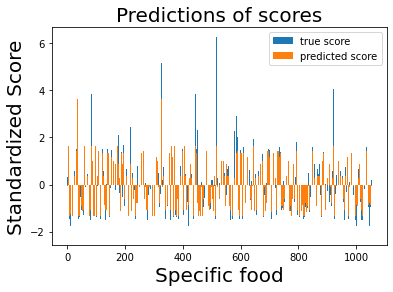

In [53]:
plt.bar(range(len(y_test)),y_test,label = 'true score')
plt.bar(range(len(y_test)),lr.predict(X_test_ohe), label = 'predicted score')
plt.xlabel('Specific food', size = 20)
plt.ylabel('Standardized Score', size = 20)
plt.legend()
plt.title('Predictions of scores', size =20)

In [25]:
#inspect ouputs
lr.intercept_ # -73148585.8

lr.coef_

array([3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12, 3.64789392e+12, 3.64789392e+12, 3.64789392e+12,
       3.64789392e+12])